# Comparison of AD and ML libraries
In this notebook we compare the *implementation and performance* of:
1. **AD** (Automatic differentiation) techniques: Zygote.jl vs Enzyme.jl
2. **ML frameworks**: Lux.jl vs SimpleChain.jl
We will focus on solving an ODE that behaves as a polinomy of 3rd degree:
$\begin{equation} du = u^3 \phi \end{equation}$
and the Neural closure should approximate the term $\phi$.

In [1]:
using SimpleChains, StaticArrays, OrdinaryDiffEq, SciMLSensitivity, Optimization,
      OptimizationOptimisers, Plots

**📢 TL;DR CONCLUSION**
- [AD] Enzyme is _faster_ than Zygote for both SimpleChain and Lux.
- [ML] Lux is faster but it uses more memory than SimpleChain.
- [ML] SimpleChain can NOT run on GPU.
- **→ Best combo:** [Enzyme + Lux]

## Setup

In [2]:
u0 = [2.0; 0.0]
du = similar(u0)
datasize = 30
tspan = [0.0, 1.5]

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u .^ 3)'true_A)'
end
t = Array(range(tspan[1], tspan[2], length = datasize))
typeof(t)
prob0 = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(
    prob0, Tsit5(), saveat = t, sensealg = DiffEqBase.SensitivityADPassThrough()))

import Random
Random.seed!(123);
rng = Random.default_rng();

## Force definition (RHS)
Force using Lux

In [3]:
using Lux
lc = Lux.Chain(
    x -> x .^ 3,
    Lux.Dense(2, 50, tanh),
    Lux.Dense(50, 2)
)
p_nn, st = Lux.setup(rng, lc)
using ComponentArrays
p_nn = ComponentArray(p_nn)
dudt_l(du, u, p, t) = begin
    du .= Lux.apply(lc, u, p, st)[1]
    nothing
end
dudt_l(du, u0, p_nn, 0.0)

Force using SimpleChain

In [4]:
sc = SimpleChain(static(2),
    Activation(x -> x .^ 3),
    TurboDense{true}(tanh, static(50)),
    TurboDense{true}(identity, static(2)))
p_nn_s = Array{Float64}(SimpleChains.init_params(sc))
p_nn_s = Array(p_nn);
#use the same parameters as Lux for a fair comparison
function dudt_sc(du::Vector{Float64}, u::Vector{Float64}, p::Vector{Float32}, t::Float64)
    du .= sc(u, p)
    nothing
end
dudt_sc(du, u0, p_nn_s, 0.0)

Comparison of forces

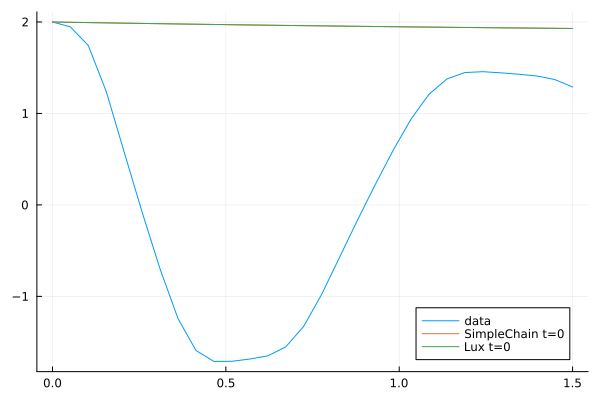

In [5]:
prob = ODEProblem{true}(dudt_sc, u0, tspan, p_nn)
sol_sc = Array(solve(prob, Tsit5(), u0 = u0, p = p_nn_s, saveat = t))
prob = ODEProblem{true}(dudt_l, u0, tspan, p_nn)
sol_l = Array(solve(prob, Tsit5(), u0 = u0, p = p_nn, saveat = t))
using Plots
plot(t, ode_data[1, :], label = "data")
plot!(t, sol_sc[1, :], label = "SimpleChain t=0")
plot!(t, sol_l[1, :], label = "Lux t=0")

## Loss functions
Subscripts: `sc` for SimpleChain and `l` for Lux

In [6]:
function loss_sc(θ::Vector{Float32})
    myprob = ODEProblem{true}(dudt_sc, u0, tspan, θ)
    pred = Array(solve(myprob, RK4(), u0 = u0, p = θ, saveat = t, verbose = false))
    return sum(abs2, ode_data - pred), pred
end
function loss_l(θ)
    myprob = ODEProblem{true}(dudt_l, u0, tspan, θ)
    pred = Array(solve(myprob, RK4(), u0 = u0, p = θ, saveat = t, verbose = false))
    return sum(abs2, ode_data - pred), pred
end

loss_l (generic function with 1 method)

This in place version is needed for Enzyme

In [7]:
function lip_sc(l::Vector{Float64}, θ::Vector{Float32}, u0::Vector{Float64},
        tspan::Vector{Float64}, t::Vector{Float64})
    myprob = ODEProblem{true}(dudt_sc, u0, tspan, θ)
    pred = Array(solve(myprob, RK4(), u0 = u0, p = θ, saveat = t, verbose = false))
    l .= Float64(sum(abs2, ode_data - pred))
    nothing
end
function lip_l(l::Vector{Float64}, θ, u0::Vector{Float64},
        tspan::Vector{Float64}, t::Vector{Float64})
    myprob = ODEProblem{true}(dudt_l, u0, tspan, θ)
    pred = Array(solve(myprob, RK4(), u0 = u0, p = θ, saveat = t, verbose = false))
    l .= Float64(sum(abs2, ode_data - pred))
    nothing
end

lip_l (generic function with 1 method)

trigger the compilation

In [ ]:
loss_sc(p_nn_s)
loss_l(p_nn)
l = [0.0]
lip_sc(l, p_nn_s, u0, tspan, t)
l = [0.0]
lip_l(l, p_nn, u0, tspan, t)

callback = function (θ, l, pred; doplot = false) #callback function to observe training
    display(l)
    #plot current prediction against data
    pl = scatter(t, ode_data[1, :], label = "data")
    scatter!(pl, t, pred[1, :], label = "prediction")
    display(plot(pl))
    return false
end
callback(p_nn_s, loss_sc(p_nn_s)...)

## Training 🏃‍➡️
### Zygote + SimpleChain

In [ ]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((p, _) -> loss_sc(p), adtype)
optprob = Optimization.OptimizationProblem(optf, p_nn_s)

result_z_s, time_z_s, alloc_z_s, gc_z_s, mem_z_s = @timed Optimization.solve(optprob,
    OptimizationOptimisers.Adam(0.05),
    callback = callback,
    maxiters = 100)

### Zygote + Lux

In [ ]:
optf = Optimization.OptimizationFunction((p, _) -> loss_l(p), adtype)
optprob = Optimization.OptimizationProblem(optf, p_nn)

result_z_l, time_z_l, alloc_z_l, gc_z_l, mem_z_l = @timed Optimization.solve(optprob,
    OptimizationOptimisers.Adam(0.05),
    callback = callback,
    maxiters = 100)

### Enzyme + SimpleChain

In [ ]:
using Enzyme
dp = Enzyme.make_zero(p_nn_s)
du0 = Enzyme.make_zero(u0)
function G_s!(G, θ::Vector{Float32}, u0_tspan_t_dp_du0::Vector{Vector{Float64}})
    u0, tspan, t, du0 = u0_tspan_t_dp_du0
    Enzyme.make_zero!(G)
    Enzyme.autodiff(Enzyme.Reverse, lip_sc, Duplicated([0.0], [1.0]), Duplicated(θ, G),
        DuplicatedNoNeed(u0, du0), Const(tspan), Const(t))
    nothing
end
G_s!(copy(dp), p_nn_s, [u0, tspan, t, du0])

optf = Optimization.OptimizationFunction(
    (p, _) -> loss_sc(p), grad = (G, p, u) -> G_s!(G, p, u))
optprob = Optimization.OptimizationProblem(optf, p_nn_s, [u0, tspan, t, du0])

result_e_s, time_e_s, alloc_e_s, gc_e_s, mem_e_s = @timed Optimization.solve(optprob,
    OptimizationOptimisers.Adam(0.05),
    callback = callback,
    maxiters = 100)

### Enzyme + Lux

In [ ]:
dp = Enzyme.make_zero(p_nn)
function G_l!(G, θ, u0_tspan_t_dp_du0::Vector{Vector{Float64}})
    u0, tspan, t, du0 = u0_tspan_t_dp_du0
    Enzyme.make_zero!(G)
    Enzyme.autodiff(Enzyme.Reverse, lip_l, Duplicated([0.0], [1.0]), Duplicated(θ, G),
        DuplicatedNoNeed(u0, du0), Const(tspan), Const(t))
    nothing
end
G_l!(copy(dp), p_nn, [u0, tspan, t, du0])

optf = Optimization.OptimizationFunction(
    (p, _) -> loss_l(p), grad = (G, p, u) -> G_l!(G, p, u))
optprob = Optimization.OptimizationProblem(optf, p_nn, [u0, tspan, t, du0])

result_e_l, time_e_l, alloc_e_l, gc_e_l, mem_e_l = @timed Optimization.solve(optprob,
    OptimizationOptimisers.Adam(0.05),
    callback = callback,
    maxiters = 100)

## Results comparison
Performance

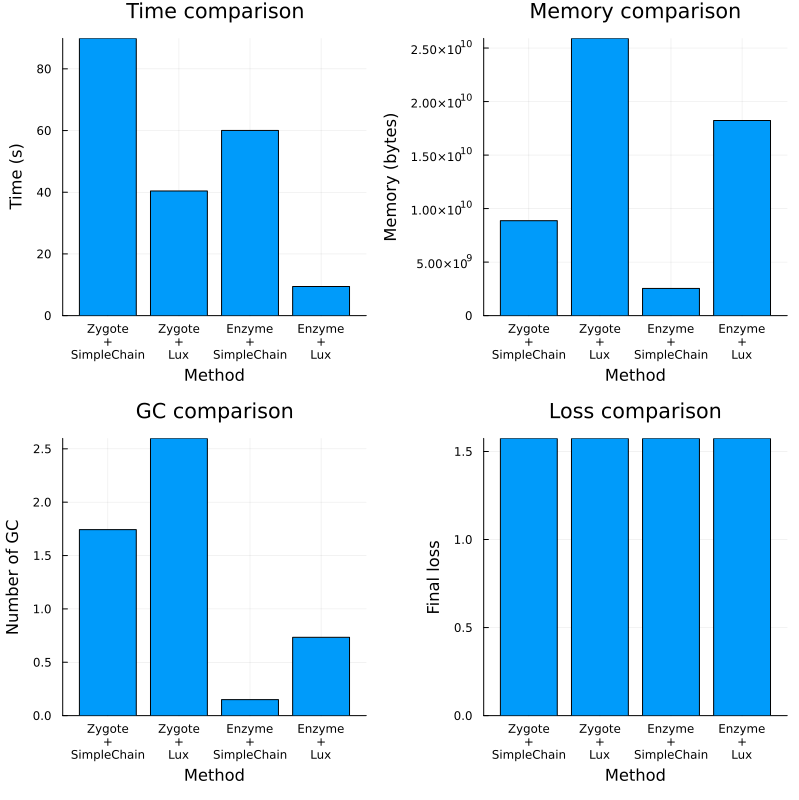

In [13]:
using Plots
p1 = Plots.bar(
    ["Zygote\n+\nSimpleChain", "Zygote\n+\nLux",
        "Enzyme\n+\nSimpleChain", "Enzyme\n+\nLux"],
    [time_z_s, time_z_l, time_e_s, time_e_l], xlabel = "Method",
    ylabel = "Time (s)", title = "Time comparison", legend = false);
p2 = Plots.bar(
    ["Zygote\n+\nSimpleChain", "Zygote\n+\nLux",
        "Enzyme\n+\nSimpleChain", "Enzyme\n+\nLux"],
    [mem_z_s.allocd, mem_z_l.allocd, mem_e_s.allocd, mem_e_l.allocd],
    xlabel = "Method", ylabel = "Memory (bytes)",
    title = "Memory comparison", legend = false);
p3 = Plots.bar(
    ["Zygote\n+\nSimpleChain", "Zygote\n+\nLux",
        "Enzyme\n+\nSimpleChain", "Enzyme\n+\nLux"],
    [gc_z_s, gc_z_l, gc_e_s, gc_e_l], xlabel = "Method",
    ylabel = "Number of GC", title = "GC comparison", legend = false);
p4 = Plots.bar(
    ["Zygote\n+\nSimpleChain", "Zygote\n+\nLux",
        "Enzyme\n+\nSimpleChain", "Enzyme\n+\nLux"],
    [result_z_s.objective, result_z_l.objective,
        result_e_s.objective, result_e_l.objective], xlabel = "Method",
    ylabel = "Final loss", title = "Loss comparison", legend = false);
#make a single plot
plot(p1, p2, p3, p4, layout = (2, 2), size = (800, 800))

Compute the different solutions

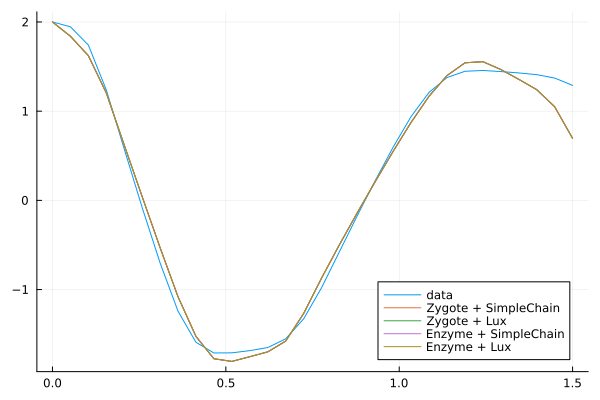

In [14]:
myprob = ODEProblem{true}(dudt_sc, u0, tspan, result_z_s.u)
pred_z_s = Array(solve(
    myprob, RK4(), u0 = u0, p = result_z_s.u, saveat = t, verbose = false))
myprob = ODEProblem{true}(dudt_l, u0, tspan, result_z_l.u)
pred_z_l = Array(solve(
    myprob, RK4(), u0 = u0, p = result_z_l.u, saveat = t, verbose = false))
myprob = ODEProblem{true}(dudt_sc, u0, tspan, result_e_s.u)
pred_e_s = Array(solve(
    myprob, RK4(), u0 = u0, p = result_e_s.u, saveat = t, verbose = false))
myprob = ODEProblem{true}(dudt_l, u0, tspan, result_e_l.u)
pred_e_l = Array(solve(
    myprob, RK4(), u0 = u0, p = result_e_l.u, saveat = t, verbose = false))
plot(t, ode_data[1, :], label = "data")
plot!(t, pred_z_s[1, :], label = "Zygote + SimpleChain")
plot!(t, pred_z_l[1, :], label = "Zygote + Lux")
plot!(t, pred_e_s[1, :], label = "Enzyme + SimpleChain")
plot!(t, pred_e_l[1, :], label = "Enzyme + Lux")

Are they identical?

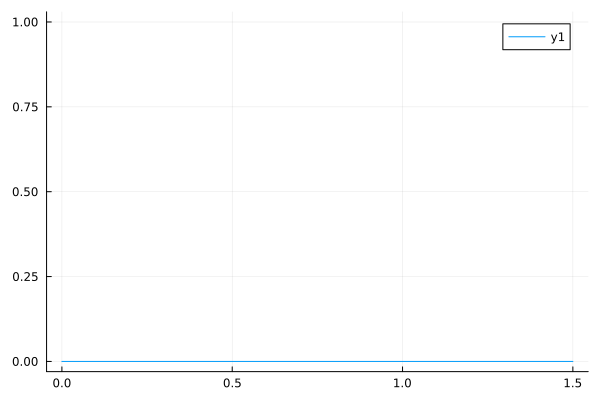

In [15]:
plot(t, pred_z_s[1, :] .- pred_z_l[1, :])
plot(t, pred_e_s[1, :] .- pred_e_l[1, :])
plot(t, pred_z_s[1, :] .- pred_e_s[1, :])
plot(t, pred_z_l[1, :] .- pred_e_l[1, :])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*